# KNMI daggegevens

https://www.knmi.nl/nederland-nu/klimatologie/daggegevens

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Set parameters

In [49]:
year = 2022

stations = {
    260: 'De Bilt',
    279: 'Hoogeveen'
}

vars = ['TG']

### Download data from url

In [15]:
start = f'{year}0101'
end = f'{year}1231'

url = 'https://www.daggegevens.knmi.nl/klimatologie/daggegevens' \
      '?stns=' + ':'.join(map(str, stations.keys())) + \
      '&vars=' + ':'.join(vars) + \
      '&start=' + start + \
      '&end=' + end

url

'https://www.daggegevens.knmi.nl/klimatologie/daggegevens?stns=260:279&vars=TG&start=20220101&end=20221231'

In [50]:
column_names = ['STN', 'YYYYMMDD'] + vars

df = pd.read_csv(url, 
                 comment = '#', 
                 names = column_names,
                 parse_dates = ['YYYYMMDD'])

print(df.shape)
display(df.head())

(730, 3)


,STN,YYYYMMDD,TG
0,260,2022-01-01,123
1,260,2022-01-02,117
2,260,2022-01-03,97
3,260,2022-01-04,65
4,260,2022-01-05,51


### or from downloaded files

In [5]:
filename1 = '../datasets/etmgeg_260.txt'    # De Bilt
filename2 = '../datasets/etmgeg_279.txt'    # Hoogeveen

In [7]:
kwargs = {'skiprows' : 47, 
          'skipinitialspace': True,
          'usecols': ['# STN', 'YYYYMMDD'] + vars,
          'parse_dates': ['YYYYMMDD']}

df1 = pd.read_csv(filename1, **kwargs).rename(columns = {'# STN':'STN'})
df2 = pd.read_csv(filename2, **kwargs).rename(columns = {'# STN':'STN'})

df = pd.concat([df1[df1['YYYYMMDD'].dt.year == year], 
                df2[df2['YYYYMMDD'].dt.year == year]]).reset_index(drop = True)

print(df.shape)
display(df.head())

(732, 3)


,STN,YYYYMMDD,TG
0,260,2020-01-01,8.0
1,260,2020-01-02,39.0
2,260,2020-01-03,76.0
3,260,2020-01-04,67.0
4,260,2020-01-05,69.0


## Convert columns

In [51]:
df['TEMPERATURE'] = df['TG'].astype('int') / 10

In [52]:
df['DD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')

In [53]:
df['STATION'] = df['STN'].astype('int').map(stations)

## Pivot to daily index

In [55]:
df_daily = df.pivot(index = 'DD', 
                    columns = 'STATION', 
                    values = 'TEMPERATURE')

In [56]:
df_daily

STATION,De Bilt,Hoogeveen
DD,,
2022-01-01,12.3,12.0
2022-01-02,11.7,11.1
2022-01-03,9.7,9.2
2022-01-04,6.5,5.5
2022-01-05,5.1,4.4
...,...,...
2022-12-27,5.7,5.0
2022-12-28,9.2,8.3
2022-12-29,9.2,9.1


# Visualisation

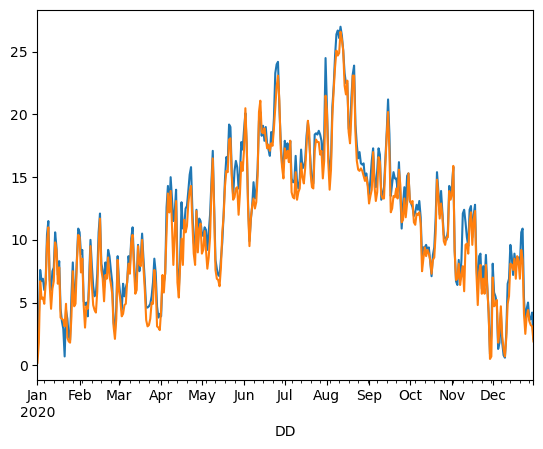

In [13]:
for station in stations.values():
    df_daily[station].plot()

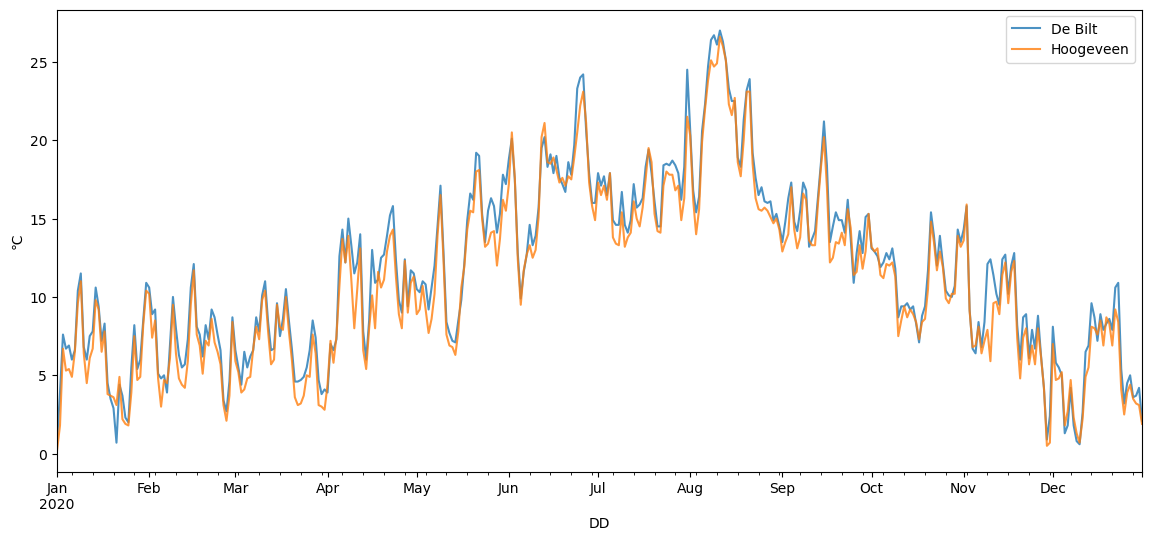

In [17]:
plt.figure(figsize=(14, 6))

for station in stations.values():
    df_daily[station].plot(alpha=0.8)

plt.ylabel('℃')
plt.legend(stations.values())
plt.show()

In [533]:
df_daily.describe()

STATION,De Bilt,Hoogeveen
count,366.000000,366.000000
mean,11.688251,10.928142
std,5.567863,5.529339
min,0.600000,0.200000
25%,7.300000,6.700000
50%,11.500000,10.450000
75%,15.700000,14.775000
max,27.000000,26.600000


<Axes: >

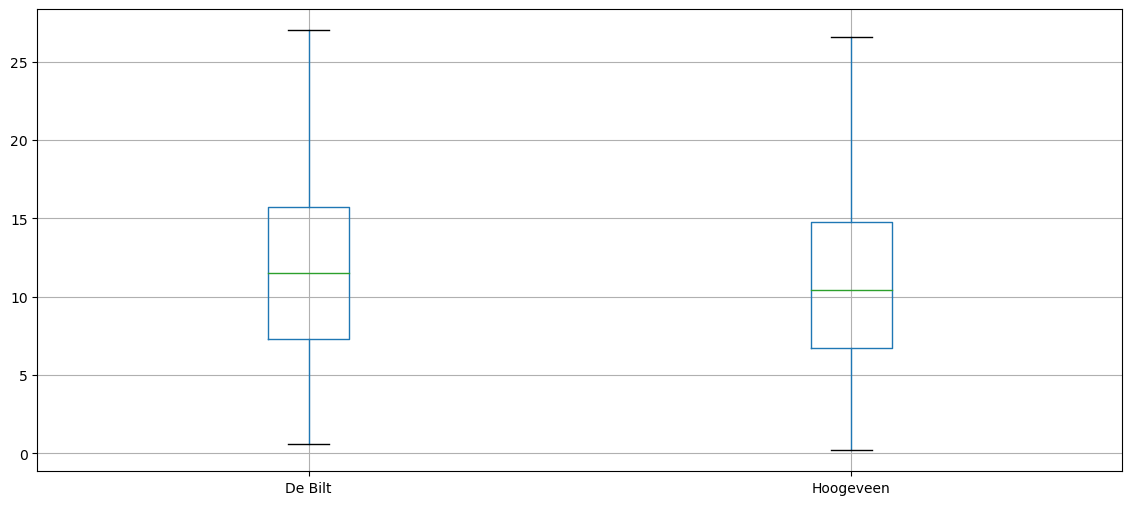

In [18]:
df_daily.boxplot(figsize=(14, 6))

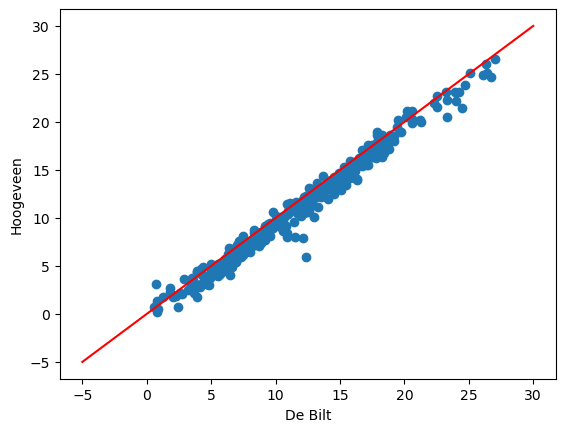

In [20]:
station1, station2 = stations.values()

plt.scatter(df_daily[station1], df_daily[station2])
plt.plot([-5, 30], [-5, 30], color='r')
plt.xlabel(station1)
plt.ylabel(station2)
plt.show()

In [536]:
n_kouder = np.sum(df_daily[station2] < df_daily[station1])
n_totaal, _ = df_daily.shape

print('Op %d van de %d dagen (%.0f%%) is het kouder in %s dan in %s' % (n_kouder, 
                                                                        n_totaal, 
                                                                        100*n_kouder/n_totaal, 
                                                                        station2, 
                                                                        station1))

Op 312 van de 366 dagen (85%) is het kouder in Hoogeveen dan in De Bilt


#### Temperatuurverschil

In [21]:
diff = df_daily[station2] - df_daily[station1]
diff

DD
2020-01-01   -0.6
2020-01-02   -2.1
2020-01-03   -0.9
2020-01-04   -1.4
2020-01-05   -1.5
             ... 
2020-12-27   -0.6
2020-12-28   -0.1
2020-12-29   -0.5
2020-12-30   -1.1
2020-12-31   -0.2
Length: 366, dtype: float64

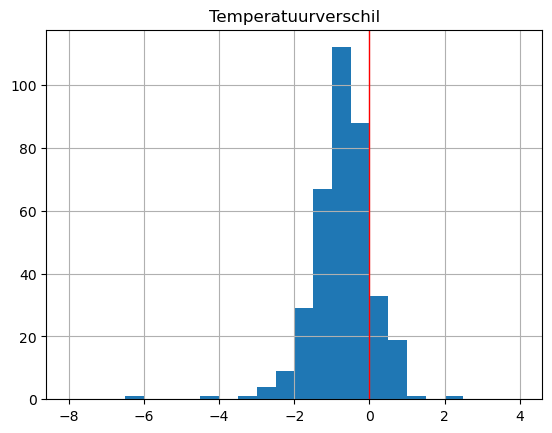

In [22]:
bins = np.arange(-8, 4.5, 0.5)
diff.hist(bins=bins)
plt.axvline(0, color='red', linewidth=1)
plt.title('Temperatuurverschil')
plt.show()

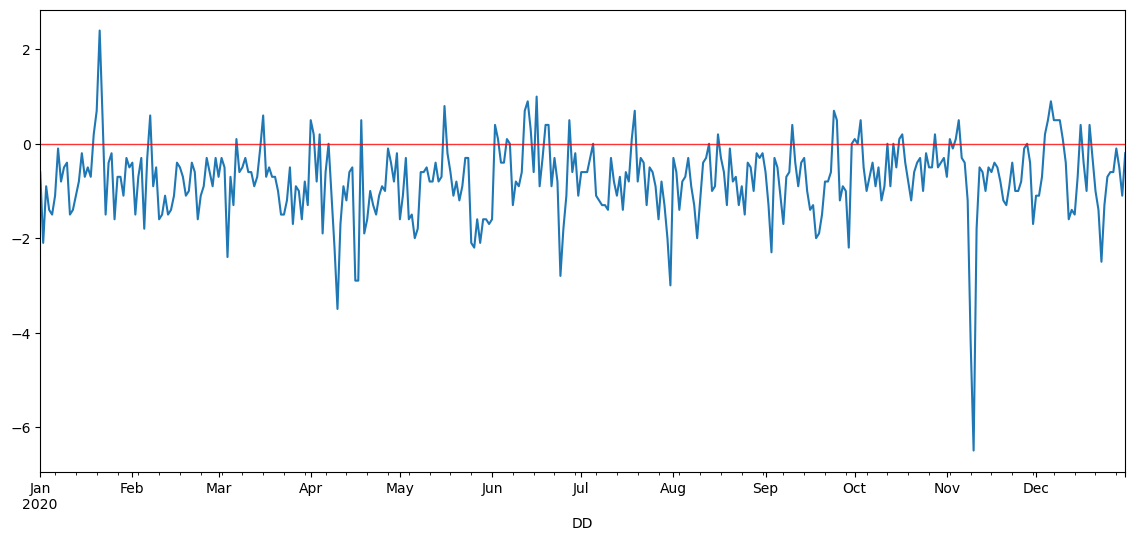

In [23]:
plt.figure(figsize=(14, 6))
diff.plot()
plt.axhline(0, color='red', linewidth=1, alpha=0.8)
plt.show()


## Student t-test

In [24]:
from scipy import stats
t, p = stats.ttest_1samp(diff, 0)
print("The t-statistic is %.3f and the p-value is %.5f." % (t, p/2))

The t-statistic is -18.156 and the p-value is 0.00000.


## Global Warming in Nederland

In [58]:
kwargs = {'skiprows' : 47, 
          'skipinitialspace': True,
          'usecols': ['YYYYMMDD', 'TG'],
          'parse_dates': ['YYYYMMDD'],
          'index_col': 0}

df = pd.read_csv(filename1, **kwargs)

In [59]:
df['TEMPERATURE'] = df['TG'] / 10

df.drop('TG', axis = 1, inplace = True)

In [60]:
df = df.truncate(before='1900-01-01', after='2020-12-31')

In [61]:
weekly = df.resample('W').mean()
monthly = df.resample('M').mean()
yearly = df.resample('Y').mean()

In [62]:
yearly

,TEMPERATURE
YYYYMMDD,
1901-12-31,8.783562
1902-12-31,8.245205
1903-12-31,9.166575
1904-12-31,8.933607
1905-12-31,8.713699
...,...
2016-12-31,10.703279
2017-12-31,10.965753
2018-12-31,11.401644


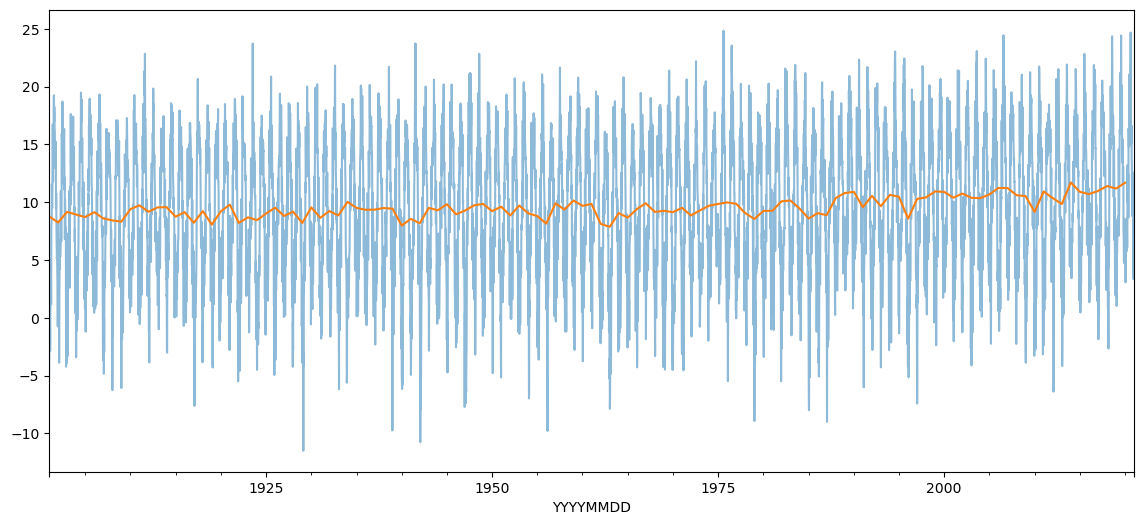

In [30]:
plt.figure(figsize=(14, 6))
weekly['TEMPERATURE'].plot(alpha=0.5)
yearly['TEMPERATURE'].plot()
plt.show()

### Fit polynomial model

In [63]:
model = np.polynomial.Polynomial.fit(yearly.index.year, yearly['TEMPERATURE'], deg = 5)

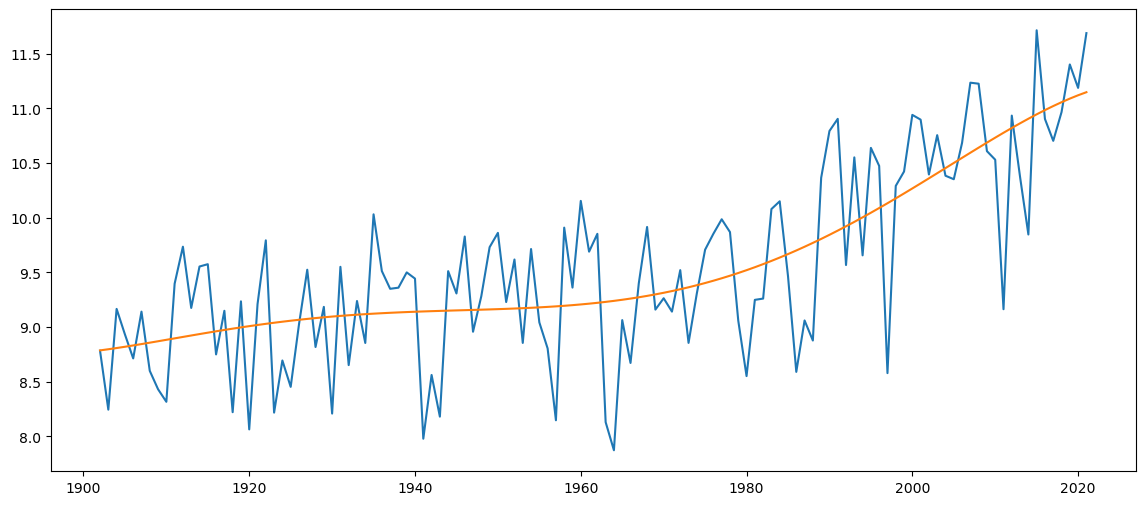

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(yearly['TEMPERATURE'])
plt.plot(yearly.index, model(yearly.index.year))
plt.show()

In [47]:
import re

def read_parts(filename):
    REGEX_DISCLAIMER = r'^BRON:|^SOURCE:'
    REGEX_DISCRIPTION = r'^\w+\s+='
    REGEX_HEADER = r'^# STN'
    REGEX_DATA = r'^\s*\d{3},'

    with open(filename) as f:
        in_part = False
        for line in f:
            if not in_part:
                if re.match(REGEX_DISCLAIMER, line):
                    print('regex_disclaimer_part')
                    in_part = True
                    skip_part = True
                    continue
                elif re.match(REGEX_DISCRIPTION, line):
                    print('regex_discription_part')
                    in_part = True
                    skip_part = True
                    continue
                elif re.match(REGEX_HEADER, line):
                    print('regex_header_part')
                    in_part = True
                    skip_part = False
                    yield line.lstrip('# ')
                elif re.match(REGEX_DATA, line):
                    print('regex_data_part')
                    in_part = True
                    skip_part = False
                    yield line
            else:
                if line.strip() == '':
                    in_part = False
                elif not skip_part:
                    yield line


def bad_lines(line):
    REGEX_DISCLAIMER = r'^BRON:|^SOURCE:'
    REGEX_DISCRIPTION = r'^\w+\s+='
    REGEX_HEADER = r'^# STN'
    REGEX_DATA = r'^\s*\d{3},'

    if line == '':
        return None
    elif re.match(REGEX_DISCLAIMER, line):
        return None
    elif re.match(REGEX_DISCRIPTION, line):
        return None
    elif line.strip() == '':
        return None
    else:
        return line


    
df = pd.read_csv(filename1, on_bad_lines = bad_lines, engine = 'python')
df


TypeError: expected string or bytes-like object